In [2]:
%matplotlib inline
import os
import numpy as np
import flopy
import subprocess
import shutil

#Create MODFLOW-2005 Model

In [3]:
# Assign name and create modflow model object
modelname = 'flow'
model_ws = os.path.join('.', 'mf2005')
exe_name = 'mf2005dbl.exe'
mf = flopy.modflow.Modflow(modelname, model_ws=model_ws, exe_name=exe_name)

In [4]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 10.
zbot = -10.
nlay = 1
nrow = 1
ncol = 10
delr = Lx/ncol
delc = Ly/nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

In [5]:
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:])

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, laytyp=1, layavg=1, hk=10., vka=10.)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf)

# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf)

In [10]:
# Write the MODFLOW model input files
if os.path.isfile(modelname+'.hds'):
    os.remove(modelname+'.hds')
mf.write_input()
success, buff = mf.run_model()

FloPy is using the following executable to run the model: Z:\Users\langevin\langevin\bin\win\mf2005dbl.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: flow.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/10  8:57:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/10  8:57:48
 Elapsed run time:  0.004 Seconds

  Normal termination of simulation


[[[ 10.           9.14890647   8.25815415   7.32161576   6.33140022
     5.27704652   4.14417019   2.91202404   1.54866527   0.        ]]]


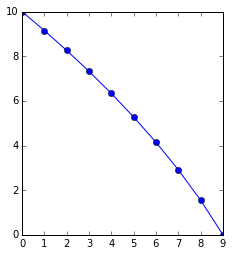

In [11]:
# Post process the results
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
plt.subplot(1, 1, 1, aspect='equal')
fname = os.path.join(model_ws, modelname + '.hds')
hdobj = bf.HeadFile(fname, precision='double')
times = hdobj.get_times()
head = hdobj.get_data(totim=times[-1])
print head
plt.plot(head[0, 0, :], 'bo-')

#MODFLOW-2015 Model

In [16]:
mf5to15 = '/Users/langevin/langevin/dev/mf2015.git/mf5to15/msvs/mf5to15/Debug/mf5to15.exe'
cwd = os.getcwd()
os.chdir(model_ws)
success = subprocess.check_call([mf5to15, modelname+'.nam', modelname+'15'])
os.chdir(cwd)

In [17]:
fnames = os.listdir(model_ws)
srclist = ['mf2015.nam']
for f in fnames:
    if modelname+'15' in f:
        srclist.append(f)
print srclist

['mf2015.nam', 'flow15.dis', 'flow15.ic', 'flow15.nam', 'flow15.npf', 'flow15.oc', 'flow15.sms', 'flow15.tdis', 'flow15_constant.chd', 'flow15_conversion_messages.txt']


In [18]:
for f in srclist:
    fname = os.path.join(model_ws, f)
    print 'moving ', fname
    if os.path.isfile(f):
        print 'Removing ', f
        os.remove(f)
    shutil.move(fname, f)

moving  .\mf2005\mf2015.nam
moving  .\mf2005\flow15.dis
moving  .\mf2005\flow15.ic
moving  .\mf2005\flow15.nam
moving  .\mf2005\flow15.npf
moving  .\mf2005\flow15.oc
moving  .\mf2005\flow15.sms
moving  .\mf2005\flow15.tdis
moving  .\mf2005\flow15_constant.chd
moving  .\mf2005\flow15_conversion_messages.txt


In [19]:
# Make oc file
mf15name = modelname + '15'
f = open(mf15name + '.oc', 'w')
s = '''
BEGIN OPTIONS
  HEAD SAVE FILE flow15_flow.hds
  BUDGET SAVE FILE flow15_flow.cbc
END OPTIONS

BEGIN PERIOD 1
  HEAD PRINT ALL
  HEAD SAVE ALL
  BUDGET PRINT ALL
  BUDGET SAVE ALL
END PERIOD
'''
f.write(s)
f.close()

In [20]:
# Modify the name file to include oc and cbc
fname = mf15name + '.nam'
with open(fname, 'r') as f:
    lines = f.readlines()

f = open('temp.nam', 'w')
for line in lines:
    if 'END Input_Files' in line:
        f.write('  OC8           flow15.oc' + '\n')
    f.write(line)
f.close()

os.remove(fname)
shutil.move('temp.nam', fname)

In [21]:
success = subprocess.check_call(['runmodel.bat'])

[[[ 10.           9.14890647   8.25815415   7.32161576   6.33140022
     5.27704652   4.14417019   2.91202404   1.54866527   0.        ]]]


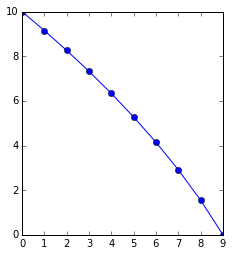

In [26]:
plt.subplot(1, 1, 1, aspect='equal')
fname = os.path.join('.', mf15name + '_flow.hds')
hdobj = bf.HeadFile(fname, precision='double')
times = hdobj.get_times()
head15 = hdobj.get_data(totim=times[-1])
print head15
plt.plot(head[0, 0, :], 'bo-')

[[[  0.00000000e+00  -2.62900812e-13  -9.39692768e-13  -1.47704071e-12
    -1.98152605e-12  -2.22311058e-12  -2.18225438e-12  -1.76125781e-12
    -1.04316555e-12   0.00000000e+00]]]


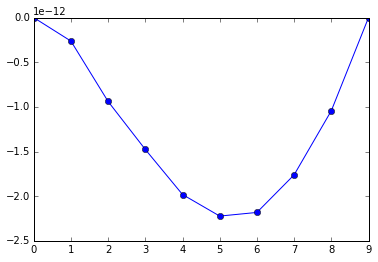

In [27]:
print head - head15
plt.plot(head[0, 0, :]-head15[0, 0, :], 'bo-')